##  <font color=MediumSlateBlue>Importing Libraries</font> ##

####  <font color=SlateBlue>Necessary Libraries</font>

In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import random

####  <font color=SlateBlue>Plotting Libraries</font>

In [2]:
from matplotlib import pyplot as plt
from tabulate import tabulate

####  <font color=SlateBlue>Google Colab</font>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####  <font color=SlateBlue>Preprocessing</font>

In [4]:
from sklearn.model_selection import train_test_split as trainTestSplitter
from sklearn.metrics import accuracy_score as AccScore
from sklearn.preprocessing import OneHotEncoder

##  <font color=MediumSlateBlue>Helping Fuctions</font> ##

####  <font color=SlateBlue>Plotting Tables Beautifully</font>

In [5]:
def plotTable(clms, clmDataHeadears, alignSize):
    data = []
    
    for i in range(len(clms[list(clms.keys())[0]])):
        dataElement = []
        for key in clms.keys():
            dataElement.append(clms[key][i])
        data.append(dataElement)
        
    print(tabulate(data, headers=clmDataHeadears, tablefmt="fancy_grid", 
                   colalign=["center"]*alignSize))

##  <font color=MediumSlateBlue>Classes</font> ##

####  <font color=SlateBlue>Neural Network</font>

In [6]:
class Network(object):

  def __init__(self, networkInfo, weightInitalization, lRateDecayType='const'):
    """
    To initialize a netwrok,  parameters are required. 
    1)networkInfo: It is a dictionary, including the number of neurons in each
                   layer, given in a list format, the type of activation functions
                   of each neuron given in list format, and the type of loss-
                   function the network uses to be trained. 
    2)weightInitalization: Various kind of initialization is implemented 
                           in the wight initialization class. Using it, the 
                           initialization for weights and biases are done.
    3)lRateDecayType: Various kinds of decay are implemented in the decay 
                         function. Based on the what is needed, its type 
                         is set.
    """
    self.numLayers = len(networkInfo['neuronSizes'])
    self.neuronSizes = networkInfo['neuronSizes']
    self.activationFuncs = networkInfo['activationFunc']
    self.lossFunc = networkInfo['lossFunc']

    self.weights = weightInitalization.giveWeight()
    self.biases = weightInitalization.giveBiases() 

    self.updatedBiases = [np.zeros(b.shape) for b in self.biases]
    self.updatedWeights  = [np.zeros(w.shape) for w in self.weights]

    self.trainCost, self.trainAccuracy = [], []
    self.evalCost, self.evalAccuracy = [], []

    self.lRateDecayType = lRateDecayType

  def forwProp(self, a):
    """
    This function performs the forward propagation, where a is the neuron's 
    activation value.
    """ 
    for b, w, actFunc in zip(self.biases, self.weights, self.activationFuncs):
        a = actFunc.func(np.dot(w, a.T)+b)
    return a

  def backProp(self, x, y):
    """
    This function preforms the back propagation, where x is a sample from 
    training data, and y is the assosiated label of it. It updates weights and 
    biases, as well as returning the values of their gradients and loss.
    """

    nablaBias = [np.zeros(b.shape) for b in self.biases]
    nablaWeight = [np.zeros(w.shape) for w in self.weights]

    #feedforward
    a = x
    alla = [x] 
    allz = [] 
    for b, w, actFunc in zip(self.biases, self.weights, self.activationFuncs):
      z = np.dot(w, a.T) + b
      allz.append(z)
      a = actFunc.func(z)
      alla.append(a)

    #backward pass
    delta = (self.lossFunc).deriv(allz[-1], alla[-1], y, self.activationFuncs[-1])
    loss = (self.lossFunc).func(alla[-1], y)

    nablaBias[-1] = np.dot(np.ones((1,len(delta))), delta).T 
    nablaWeight[-1] = np.dot(alla[-2].transpose(), delta).T

    for indx in range(2, self.numLayers):
      z = allz[-indx]
      actDeriv = (self.activationFuncs[-indx]).deriv(z)
      delta = np.multiply(np.dot(delta, self.weights[-indx+1]), actDeriv.T)

      nablaBias[-indx] = np.dot(delta.T, np.ones((len(delta),1)))
      nablaWeight[-indx] = np.dot(delta.T, alla[-indx-1])

    return (nablaBias, nablaWeight, loss)

  def miniBatchTrain(self, trainBatchData, trainBatchLabels, 
                     eta, momentum, lmbda, n):
    """
    This function is for updating weights and baises of a mini batch of data. It
    requires training data and lables to be passed as batches, as well as eta 
    (learning rate), momentum, and lambda to adjust the hyperparameters while 
    updating weights and biases. In the end, it'll return the loss each batch 
    faces. 
    """
    nablaBias, nablaWeight, lossBatch = self.backProp(trainBatchData, trainBatchLabels)

    self.weights = [(1-eta*(lmbda/n))*w-(eta/len(trainBatchData))*nw + momentum*dw for w, nw, dw in zip(self.weights, nablaWeight, self.updatedWeights)]
    self.biases = [b-(eta/len(trainBatchData))*nb + momentum*db for b, nb, db in zip(self.biases, nablaBias, self.updatedBiases)]

    self.updatedWeights = [-(eta/len(trainBatchData))*dw for dw in nablaWeight]
    self.updatedBiases = [-(eta/len(trainBatchData))*dw for dw in nablaBias]
    
    return lossBatch

  def calcAccuracy(self, data, dataLabels, batch=True): 
    return AccScore(np.argmax(self.forwProp(data), axis=1), 
                    np.argmax(dataLabels, axis=1)) if batch else AccScore(np.argmax(self.forwProp(data), axis=1), dataLabels)
    
  def networkTrain(self, trainData, lenTrainData, evalData, 
                   epochs, eta, momentum, lmbda = 0.0):

    for epoch in range(epochs):
      trainLoss, evalLoss = 0.0, 0.0 
      trainAcc, evalAcc = 0.0, 0.0

      #Train
      cnt = 0
      for trainBatchData, trainBatchLabels in trainData:
        trainLoss += self.miniBatchTrain(trainBatchData, trainBatchLabels.T, 
                                         eta, momentum, lmbda, lenTrainData)
        cnt +=1
        trainAcc += self.calcAccuracy(trainBatchData, trainBatchLabels)

      self.trainCost.append(trainLoss/cnt)
      self.trainAccuracy.append(trainAcc/cnt)

      cnt = 0
      for evalBatchData, evalBatchLabels in evalData:
         evalLoss += (self.lossFunc).func(self.forwProp(evalBatchData), 
                                          evalBatchLabels.T)
         cnt +=1
         evalAcc += self.calcAccuracy(evalBatchData, evalBatchLabels)

      self.evalCost.append(evalLoss/cnt)
      self.evalAccuracy.append(evalAcc/cnt)
    
  def plotCosts(self, plotTrainCost=True, plotEvalCost=True):
    if plotTrainCost:
      plt.plot(np.sqrt(self.trainCost), label='Train Loss', color='mediumpurple')
    if plotEvalCost:
      plt.plot(np.sqrt(self.evalCost), label='Evaluation Loss', color='slateblue')

    plt.title('Loss vs. Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()

  def plotAccuracy(self, plotTrainAcc=True, plotEvalAcc=True):
    if plotTrainAcc:
      plt.plot(self.trainAccuracy, label='Train Accuracy', color='mediumpurple')
    if plotEvalAcc:
      plt.plot(self.evalAccuracy, label='Evaluation Accuracy', color='slateblue')

    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()


####  <font color=SlateBlue>Weight Initialization</font>

In [7]:
class weightInit(object):

  def __init__(self, networkLayers, initType='random'):
    """
    'networkLayers' is a list containing the number of neurons in each layer of 
    the network.
    'initType' is the desired type of weight initialization. 
    """
    self.networkLayers = networkLayers
    self.initType = initType
    self.runInitiType()

  def randomInit(self):
    """
    Random initailzation for the weights while bias is zero. 
    """
    self.biases = [np.zeros((numNeuron, 1)) for numNeuron in self.networkLayers[1:]]
    self.weights = [np.random.randn(numNeuron, numNeuronNxt)/np.sqrt(numNeuronNxt) for numNeuronNxt, numNeuron in zip(self.networkLayers[:-1], self.networkLayers[1:])]

  def zeroInit(self):
    """
    Zero intialization for both weights and biases. 
    """
    self.biases = [np.zeros((numNeuron, 1)) for numNeuron in self.networkLayers[1:]]
    self.weights = [np.zeros((numNeuron, numNeuronNxt))/np.sqrt(numNeuronNxt) for numNeuronNxt, numNeuron in zip(self.networkLayers[:-1], self.networkLayers[1:])]

  def xavierInit(self):
    """
    Xavier initailzation for the weights while bias is zero. 
    """
    self.biases = [np.zeros((numNeuron, 1)) for numNeuron in self.networkLayers[1:]]
    self.weights = [np.sqrt(2)*np.random.randn(numNeuron, numNeuronNxt)/np.sqrt(numNeuronNxt) for numNeuronNxt, numNeuron in zip(self.networkLayers[:-1], self.networkLayers[1:])]

  def runInitiType(self):
    """
    Run initialization of parameters based on the given choice.
    """
    if self.initType == 'random':
      self.randomInit()
    elif self.initType == 'zero':
      self.zeroInit()
    elif self.initType == 'xavier':
      self.xavierInit()
    
  def giveWeight(self): return self.weights

  def giveBiases(self): return self.biases   



####  <font color=SlateBlue>Leaky ReLU and its Derivative</font>

In [8]:
class leakyReLU(object):

  def __init__(self, slope=0.01):
    """
    Based on the given slope, the slope for inputs less than zaro is determined. 
    """
    self.slope = slope 

  def func(self, data): return np.multiply(data, (data<0)*self.slope+(data>0)).T

  def deriv(self, data): return np.heaviside(data, self.slope)

####  <font color=SlateBlue>SoftMax and its Derivative</font>

In [9]:
class SoftMax(object):

  def __init__(self): pass
  
  def func(self, x):
    x = x.T
    num = np.exp(x)
    denum = num.sum(axis=1)
    denum = denum[:, np.newaxis].reshape(len(num),1)

    return num/denum
    
  def deriv(self, x):
    return np.ones(np.shape(x))

####  <font color=SlateBlue>L2 cost and its derivative</font>

In [10]:
class L2Cost(object):

  def __init__(self): pass

  def func(self, a, y): return LA.norm(a-y)**2/(2*len(y))

  def deriv(self, z, a, y, actFunc): return np.multiply((a-y), actFunc.deriv(z).T)


####  <font color=SlateBlue>Negative log likelihood cost and its derivative</font>

In [11]:
class NLLCost(object):

  def __init__(self):pass
  
  def func(self, a, y):
    y = (y.T).reshape(np.shape(a))
    return np.mean(np.sum(-1*np.multiply(y, np.log((a))), axis=1))

  def deriv(self, z, a, y, actFunc):
    return (a-y.T)


####  <font color=SlateBlue>Create batches of data with given size</font>

In [12]:
class BatchDataCreator():

  def __init__(self, data, dataLabels, batchSize):
    self.data = data
    self.dataLabels = dataLabels
    self.batchSize = batchSize

  def __iter__(self):
    for indx in range(0, len(self.data), self.batchSize):
      yield (np.matrix(self.data[indx:indx+self.batchSize]), 
             np.matrix(self.dataLabels[indx:indx+self.batchSize]))
      

##  <font color=MediumSlateBlue>Main Code</font> ##

####  <font color=SlateBlue>Read Dataset</font>

In [51]:
myData = []
for i in range(20):
  tmpData =  pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/Deep Learning/HW/1/Dataset/Reduced_UTKFace/dataset'+str(i)+'.csv').values
  myData.append(tmpData)
myData = np.asarray(myData).reshape(20*1000,131)
np.random.shuffle(myData)

temp = []
for i in range(0,20000):
  if myData[i,130] == 0.0 or myData[i,130] == 1.0 or myData[i,130] == 2.0 or myData[i,130] == 3.0 or myData[i,130] == 4.0:
    temp.append(myData[i,:])
myData = np.asarray(temp).reshape(len(temp),131)

trainData, testData, trainLabels, testLabels = trainTestSplitter(myData[:,0:128], myData[:,130], test_size=0.1, random_state=42)
trainData, evalData, trainLabels, evalLabels = trainTestSplitter(trainData, trainLabels, test_size=0.1, random_state=42)

econderOneHot = OneHotEncoder(sparse=False)
trainLabels = econderOneHot.fit_transform(trainLabels.reshape(len(trainLabels), 1))
evalLabels = econderOneHot.transform(evalLabels.reshape(len(evalLabels), 1))

trainBatch = BatchDataCreator(data=trainData, dataLabels = trainLabels, batchSize = 128)
evalBatch =  BatchDataCreator(data = evalData, dataLabels = evalLabels, batchSize = 128)

####  <font color=SlateBlue>Train network with best parameters for 1000 epochs</font>

In [41]:
networkInformation = {'neuronSizes':[128, 64, 5], 
                      'activationFunc':[leakyReLU(), SoftMax()], 
                      'lossFunc':NLLCost()}

myNet = Network(networkInfo=networkInformation, 
                weightInitalization=weightInit([128,64, 5]))

myNet.networkTrain(trainData=trainBatch, 
                   lenTrainData=len(trainData), 
                   evalData=evalBatch, 
                   epochs=1000, 
                   eta=0.001, 
                   lmbda=0.0, 
                   momentum=0.9)

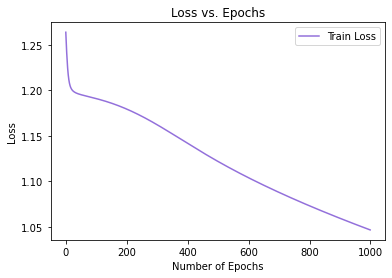

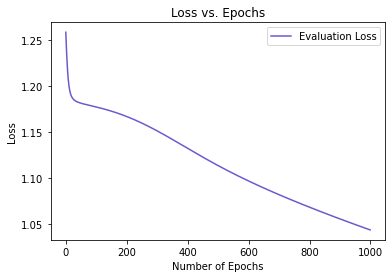

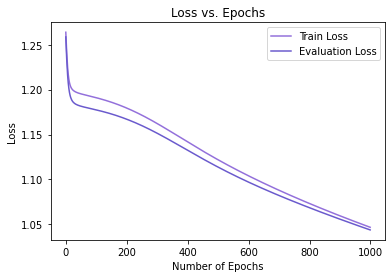

In [42]:
myNet.plotCosts(plotTrainCost=True, plotEvalCost=False)
myNet.plotCosts(plotTrainCost=False, plotEvalCost=True)
myNet.plotCosts(plotTrainCost=True, plotEvalCost=True)

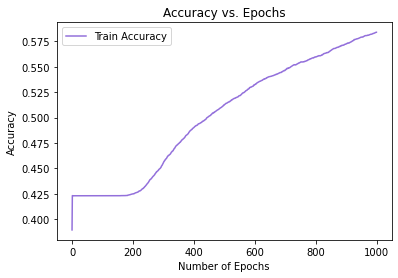

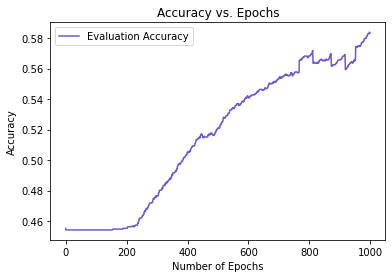

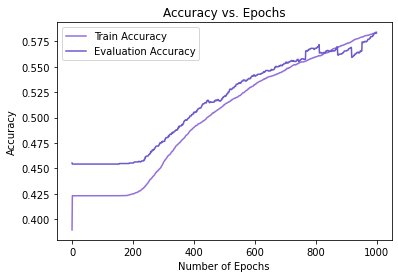

In [43]:
myNet.plotAccuracy(plotTrainAcc=True, plotEvalAcc=False)
myNet.plotAccuracy(plotTrainAcc=False, plotEvalAcc=True)
myNet.plotAccuracy(plotTrainAcc=True, plotEvalAcc=True)

In [45]:
print('Accuracy of the trained model on test data is:' ,myNet.calcAccuracy(testData, testLabels, False)*100)

Accuracy of the trained model on test data is: 59.9


####  <font color=SlateBlue>Train network with best parameters for 8000 epochs</font>

In [47]:
networkInformation = {'neuronSizes':[128, 64, 5], 
                      'activationFunc':[leakyReLU(), SoftMax()], 
                      'lossFunc':NLLCost()}

myNet = Network(networkInfo=networkInformation, 
                weightInitalization=weightInit([128,64, 5]))

myNet.networkTrain(trainData=trainBatch, 
                   lenTrainData=len(trainData), 
                   evalData=evalBatch, 
                   epochs=8000, 
                   eta=0.001, 
                   lmbda=0.0, 
                   momentum=0.9)

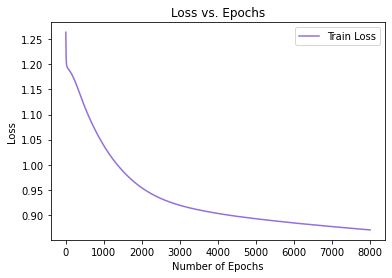

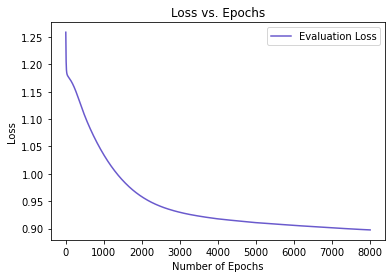

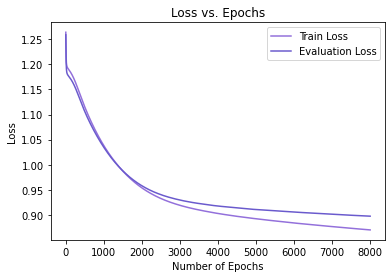

In [48]:
myNet.plotCosts(plotTrainCost=True, plotEvalCost=False)
myNet.plotCosts(plotTrainCost=False, plotEvalCost=True)
myNet.plotCosts(plotTrainCost=True, plotEvalCost=True)

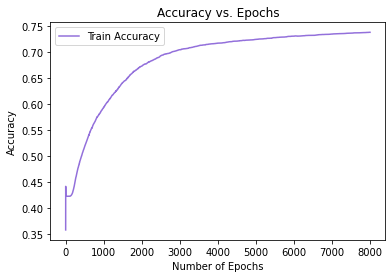

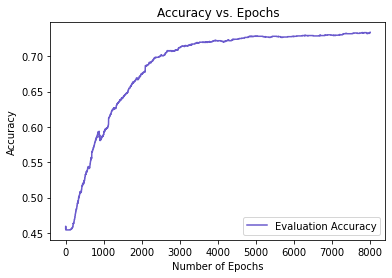

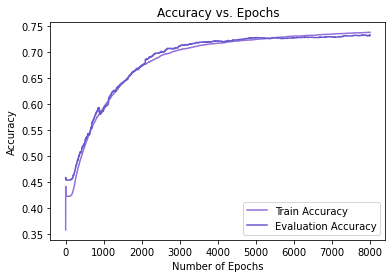

In [49]:
myNet.plotAccuracy(plotTrainAcc=True, plotEvalAcc=False)
myNet.plotAccuracy(plotTrainAcc=False, plotEvalAcc=True)
myNet.plotAccuracy(plotTrainAcc=True, plotEvalAcc=True)

In [50]:
print('Accuracy of the trained model on test data is:' ,myNet.calcAccuracy(testData, testLabels, False)*100)

Accuracy of the trained model on test data is: 72.7
